# CHEM 560 Final Project

## Contributors: Ivan Chernyshev, Ben Link, Aodong Liu, Qirui Guo

## Introduction
The structure of atoms and molecules is described by quantum mechanics, and quantum computers can simulate them better than traditional computers. Finding solutions to the structure problems traditionally requires high-performance computers with a computational cost that scales exponentially with the size of the system. But the optimization of molecular energies using medium-sized quantum computers has proven efficient for few-electron molecules. 

The question we are interested in is to find the lowest energies of molecular Hydrogen Hamiltonian as a function of hydrogen-hydrogen bond length $R$, to within chemical accuracy ($1.6\times e^{-3}$ hartree). The ground-state energy of the the Hamiltonian defines an energy surface that is used to compute chemical reaction rates, which can be used in other molecular dynamics simulations.

In CHEM560, we experimented on the variational quantum eigensolver (VQE) to solve for this problem. In this project, we will demonstrate another algorithm of quantum simulation using Trotterized simulation and the quantum phase estimation algorithm (PEA)<sup>[1]</sup>. 

### Quantum Phase Estimation

Quantum Phase Estimation Algorithm (PEA) is an algorithm to estimate the phase (or eigenvalue) of an eigenvector of a unitary operator. The general PEA curcuit contains some ancilla qubits to represent the state $|\psi\rangle$ and $n$ qubits for the counting register. The intuition of the algorithm is to use phase kickback to write the phase of $U$ to the counting register in the Fourier basis, and then use the inverse QFT to translate it into the computational basis for measurement. The problem with PEA is that it takes $n$ qubits to measure the phase up to n-bit precision. When excuting the algorithm on an actual quantum computer, the multi-qubit gate errors from the $n$ CNOT gates brings impresicion. The error can be avoided by reducing the number of qubits we use, which leads to the Iterative Quantum Phase Estimation (IQPE) Algorithm that we will be using in this project.

The Iterative Quantum Phase Estimation algorithm implements quantum phase estimation using only one auxiliary qubit, hence the accuracy of the algorithm is restricted by the number of iterations instead of the number of counting qubits, reducing the costs for hardware requirements and gate errors.

Given a unitary operator $U$, where all the eigenvalues have a norm of 1, the algorithm estimates $U\vert\psi \rangle =e^{2\pi i \theta }|\psi \rangle$. The quantum state $|\psi\rangle$ is an eigenvector and $e^{2\pi i\theta}$ is the corresponding eigenvalue <sup>[6]</sup>. We can write the eigenvalue problem as $U |\Psi\rangle = e^{i \phi} | \Psi \rangle$, with $\phi = 2 \pi \varphi=2\pi( \varphi_1/2 + \varphi_2/4 + ... + \varphi_m/2^m) =2\pi (0.\varphi_1 \varphi_2 ... \varphi_m)$.

Assume we have a system of two qubits, $q_0$ and $q_1$, where $q_0$ is auxiliary qubit and $q_1$ represents the physical system on which the unitary $U$ operates. We initialize them as $q_0 \rightarrow |+\rangle$ and $q_1 \rightarrow |\Psi \rangle$, and apply control-U between $q_0$ and $q_1$ $2^t$ times to change the state of $q_0$ to $|0\rangle + e^{i 2 \pi 2^{t} \varphi} | 1 \rangle$. In other words, the phase of $U$ has been kicked back into $q_0$ as many times as the control operation has been performed.

For $t=0$, the phase encoded into $q_0$ would be $e^{i 2 \pi 2^{0} \varphi} = e^{i 2 \pi \varphi} = e^{i 2 \pi 0.\varphi_1 \varphi_2 ... \varphi_m}$.

For $t=1$, the phase would be $e^{i 2 \pi 2^{1} \varphi} = e^{i 2 \pi \varphi_1} e^{i 2 \pi 0.\varphi_2 \varphi_3 ... \varphi_m}$.

...

For $t=m-1$, $e^{i 2 \pi 2^{m-1} \varphi} = e^{i 2 \pi 2^{m-2} \varphi_1} e^{i 2 \pi 2^{m-3} \varphi_2} ... e^{i 2 \pi 2^{-1} \varphi_m} = e^{i 2 \pi 0.\varphi_m}$.

Here, the state of $q_0$ is $|0\rangle + e^{i 2 \pi 0.\varphi_m}|1\rangle$, which gives $|+\rangle$ if $\varphi_m = 0$ and $|-\rangle$ if $\varphi_m = 1$. When we measure $q_0$ in x-basis, the result will be $|0\rangle$ and $|1\rangle$, respectively.

In the first step, we directly measure the least significant bit $\varphi_m$ by initializing the 2-qubit registers as described above ( $q_0 \rightarrow |+\rangle$ and $q_1 \rightarrow |\Psi \rangle$ ), performing $2^{m-1}$ control-$U$ operations between the qubits, and measuring $q_0$ in the x-basis.

In the second step, we initialize the systems in the same way and apply $2^{m-2}$ control-$U$ operations. The relative phase in $q_0$ after these operations now becomes $e^{i 2 \pi 0.\varphi_{m-1}\varphi_{m}}= e^{i 2 \pi 0.\varphi_{m-1}} e^{i 2 \pi \varphi_m/4}$. 
To extract the phase bit $\varphi_{m-1}$, we first need to perform a phase correction by rotating around the $Z-$axis of angle $-2 \pi \varphi_m/4=-\pi \varphi_m/2$, which results in the state of  $q_0$ to be $|0\rangle + e^{i 2 \pi 0.\varphi_{m-1}} | 1 \rangle$. A measurement on $q_0$ in x-basis gives the phase bit $\varphi_{m-1}$.

In iteration, the $k$th step requires the application of control-$U$ $2^{m-k}$ times, a rotation around $Z$ of angle $\omega_k = -2 \pi 0.0\varphi_{m-k+2} ... \varphi_m$, and a measurement of $q_0$ in x-basis to obtain $\varphi_{m-k+1}$,: a Hadamard transform to $q_0$, and a measurement of $q_0$ in the standard basis<sup>[7]</sup>.

### Trotterization approximation to the time-evolution operator

PEA works by preparing an initial state on the main qubit register, y-rotating the ancilla qubit's state into a superposition of $|0\rangle$ and $|1\rangle$, applying the unitary $U$ to the main qubit register controlled on the ancilla, reversing the y-rotation, and measuring. For the molecular energies we are interested in, the unitary matrix will be the time evolution operator representing the Hamiltonian. One of the most common ways to implement time evolution is through Trotterization.

As we in this class, Chemistry 560, learned when we implemented the Variational Quantum Eigensolver (VQE), it is not always straightforward to express a Hamiltonian directly on a quantum device. One way to remedy this issue is to decompose the Hamiltonian into tensor products of Pauli matrices. For the second-quantized hydrogen molecular Hamiltonian in the Hartree-Fock basis encoded using the Bravyi-Kitaev encoding, this would come in the form<sup>[1]</sup>

$\hat{H} = g_0 {\bf{I}} \otimes {\bf{I}}  + g_1 Z \otimes {\bf{I}} + g_2 {\bf{I}} \otimes Z + g_3 Z \otimes Z + g_4 X \otimes X + g_5 Y \otimes Y $

where the g's are constant coefficients set by the hydrogen bond length.

The time evolution can then be done by doing each of the components in sequence<sup>[1]</sup>:

$e^{-\it{i}\hat{H}t} = e^{-\it{i}g_0 t} e^{-\it{i}g_1 t Z \otimes {\bf{I}}} e^{-\it{i} g_2 t {\bf{I}} \otimes Z} e^{-\it{i} g_3 t Z \otimes Z} e^{-\it{i} g_4 t X \otimes X} e^{-\it{i} g_5 t Y \otimes Y}$ **(1)**

Now, according to the Baker-Campbell-Hausdorff formula, addition of non-commuting exponentials works as follows:

$e^X e^Y = e^{X + Y + \frac{1}{2}[X, Y] + \frac{1}{12}[X,[X,Y]] - \frac{1}{12}[Y,[X,Y]] + ... }$

This is our first source of error. To next-to-leading order in time, the decomposition in Equation 1 in practice equates to<sup>[2]</sup> 

$\Pi_{k=0}^n e^{-\it{i}\hat{H}_k t} = e^{-\it{i} \sum_{k=0}^n \hat{H}_k t - \frac{t^2}{2}\sum_{j=0}^{n-1}\sum_{k=j+1}^n[\hat{H}_j, \hat{H}_k] + O(t^3)}$

This error becomes less pronounced as one shrinks the step-size. Hence, one can compute the time-evolution as a sequence of time-evolutions over smaller time-steps:<sup>[1]</sup>

$e^{-\it{i} \sum_{k=0}^n \hat{H}_k t} \approx (\Pi_{k = 0}^n e^{-\it{i} \hat{H}_k \frac{t}{n}})^n$

and the error in the exponential would be $\propto \frac{t^2}{2 n}\sum_{j=0}^n\sum_{k=j+1}^n[\hat{H}_j, \hat{H}_k] $ <sup>[2]</sup>
    
This is called first-order Trotterization. Second-order Trotterization eliminates $O(t^2)$ error through the following formulation<sup>[3]</sup>: 
    
$e^{-\it{i} \sum_{k=0}^n \hat{H}_k t + O(t^3)} = \Pi_{k = 0}^n e^{-\it{i} \hat{H}_k \frac{t}{2}} \Pi_{k = n}^0 e^{-\it{i} \hat{H}_k \frac{t}{2}} \equiv U_S^2(t)$

Similarly, for 2k-order Trotterization<sup>[3]</sup>,

$  e^{-\it{i} \sum_{k=0}^n \hat{H}_k t + O(t^{(2k+1)})} = (U_S^{2k - 2}(p_k t))^2 U_S^{2k - 2}((1-4p_k)t)(U_S^{2k - 2}(p_k t))^2  \equiv U_S^{2k}(t)$

where $p_k = 1/(4 - 4^{\frac{1}{2k - 1}})$

### Implementation in PEA
Application of the Trotterization $(\Pi_{k = 0}^n e^{-\it{i}g_k\hat{H}_k \frac{t}{n}})^n$ introduces a phase on the register:

$e^{-i H t}|\phi\rangle = (\sum_n e^{-i E_n t}|n\rangle \langle n|)|\phi\rangle=\sum_n a_n e^{-i E_n t}|n\rangle $

where $|n\rangle$ are eigenstates such that $H|n\rangle=E_n|n\rangle$ and $a_n=\langle n|\phi\rangle$.

The ancilla is intialized in the superposition state $(|0\rangle+|1\rangle)/2$. By controlling the Trotterized evolution on the ancilla, we entangle the register with the ancilla. Then measurement of the phase between the $|0\rangle$ and the $|1\rangle$ state of the ancilla gives the phase $E_nt$ and collaspes the register to the eigenstate $|n\rangle$ with probability $|a_n|^2$.

In our implementation, at iterative step $k$, the rotation $Z_{\Phi(k)}$ that serves as phase kickback contains the classical information from the previous $k-1$ measurements

$\Phi(k)=\pi\sum_{l=0}^{k-1}\frac{j_l}{2^{l-k+1}}$.

The iterative phase estimation then gives us the phase accumulated on the system. bacause our initial Hartree-Fock state ovelaps with the ground state well ($|\langle0|\phi\rangle|^2>0.5$), we can measure each bit individually with a majority-voting rule. For $b$ bits, the ground-state energy is the binary expansion of the measurement result,

$E_0^b=-\frac{\pi}{t_0}\sum_{k=0}^{b-1}\frac{j_k}{2^{k+1}}$<sup>[1]</sup>.

### Trotterization

In [7]:

def Hexact(g0,g1,g2,g3,g4,g5):
    return np.array([[g0 + g1 + g2 + g3, 0, 0, g4 - g5], [0, g0 + g1 - g2 - g3, g4 + g5, 0], [0, g4 + g5, g0 - g1 + g2 - g3, 0], [g4 - g5, 0, 0, g0 - g1 - g2 + g3]])


In [8]:
# For the minimal energy, R0 = 0.7
H07 = Hexact(-0.4584,0.3593,-0.4826,0.5818,0.0896,0.0896)

In [9]:
initialstate = np.array([0,0,1,0])
ts07 = [0.01*i for i in range(2000)]

timeev07 = np.array([linalg.expm(-(1j)*t*H07) for t in ts07])

finalstates07 = np.array([np.matmul(u, initialstate) for u in timeev07])

In [10]:
initoverlaps07 = np.array([np.dot(initialstate,fs)*np.conjugate(np.dot(initialstate,fs)) for fs in finalstates07])
energies07 = np.array([np.dot(np.dot(fs,H07),fs) for fs in finalstates07])

/Users/blink/Applications/anaconda3/envs/qiskit_environment/lib/python3.10/site-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


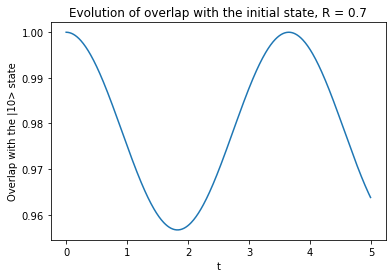

In [11]:
# Plot 
plt.title("Evolution of overlap with the initial state, R = 0.7")
plt.ylabel("Overlap with the |10> state")
plt.xlabel("t")
plt.plot(ts07[:500], initoverlaps07[:500])
plt.show()

/Users/blink/Applications/anaconda3/envs/qiskit_environment/lib/python3.10/site-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


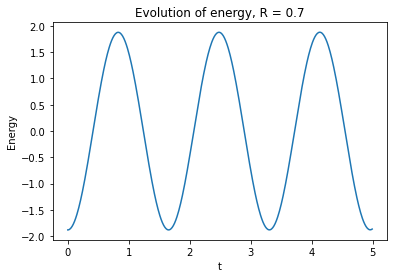

In [12]:
plt.title("Evolution of energy, R = 0.7")
plt.ylabel("Energy")
plt.xlabel("t")
plt.plot(ts07[:500], energies07[:500])
plt.show()

In [13]:
# For R0 = 0.65
H065 = Hexact(-0.4323,0.3760,-0.5358,0.5921,0.0883,0.0883)

In [14]:
initialstate = np.array([0,0,1,0])
ts065 = [0.01*i for i in range(2000)]

timeev065 = np.array([linalg.expm(-(1j)*t*H065) for t in ts065])

finalstates065 = np.array([np.matmul(u, initialstate) for u in timeev065])

In [15]:
initoverlaps065 = np.array([np.dot(initialstate,fs)*np.conjugate(np.dot(initialstate,fs)) for fs in finalstates065])
energies065 = np.array([np.dot(np.dot(fs,H065),fs) for fs in finalstates065])

/Users/blink/Applications/anaconda3/envs/qiskit_environment/lib/python3.10/site-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


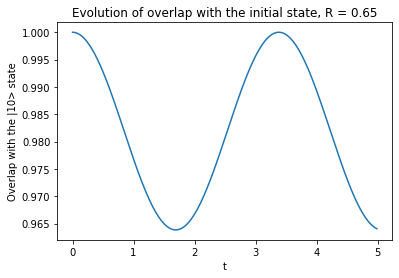

In [16]:
# Plot 
plt.title("Evolution of overlap with the initial state, R = 0.65")
plt.ylabel("Overlap with the |10> state")
plt.xlabel("t")
plt.plot(ts065[:500], initoverlaps065[:500])
plt.show()

/Users/blink/Applications/anaconda3/envs/qiskit_environment/lib/python3.10/site-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


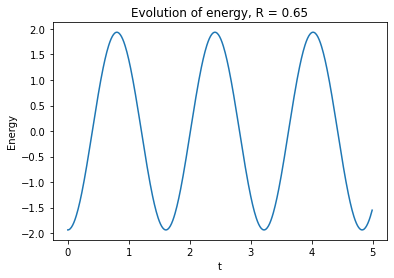

In [17]:
plt.title("Evolution of energy, R = 0.65")
plt.ylabel("Energy")
plt.xlabel("t")
plt.plot(ts065[:500], energies065[:500])
plt.show()

In [18]:
# For R0 = 0.75
H075 = Hexact(-0.4804,0.3435,-0.4347,0.5716,0.0910,0.0910)

In [19]:
initialstate = np.array([0,0,1,0])
ts075 = [0.01*i for i in range(2000)]

timeev075 = np.array([linalg.expm(-(1j)*t*H075) for t in ts075])

finalstates075 = np.array([np.matmul(u, initialstate) for u in timeev075])

In [20]:
initoverlaps075 = np.array([np.dot(initialstate,fs)*np.conjugate(np.dot(initialstate,fs)) for fs in finalstates075])
energies075 = np.array([np.dot(np.dot(fs,H075),fs) for fs in finalstates075])

/Users/blink/Applications/anaconda3/envs/qiskit_environment/lib/python3.10/site-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


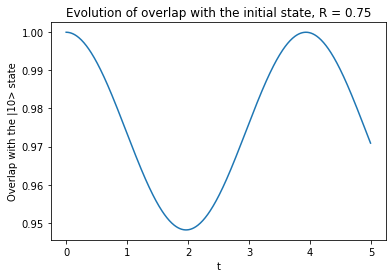

In [21]:
# Plot 
plt.title("Evolution of overlap with the initial state, R = 0.75")
plt.ylabel("Overlap with the |10> state")
plt.xlabel("t")
plt.plot(ts075[:500], initoverlaps075[:500])
plt.show()

/Users/blink/Applications/anaconda3/envs/qiskit_environment/lib/python3.10/site-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


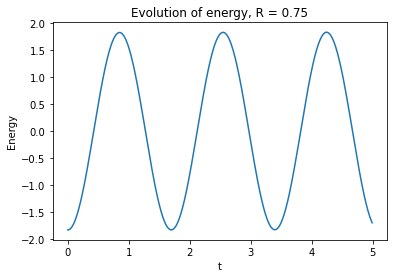

In [22]:
plt.title("Evolution of energy, R = 0.75")
plt.ylabel("Energy")
plt.xlabel("t")
plt.plot(ts075[:500], energies075[:500])
plt.show()

## Conclusion

We performed the implementation of Trotterized time-evolution operator and measure the molecular energy using iterative PEA. The trotterized time evolution is controlled on ancilla qubit and the phase-kickback rotation on the qubit determined by previous measurements to fully measure the phase.

As a result, we observed a dependence of PEA results on the number of Trotter steps that we used and the number of phase estimation steps. When we compare the result to the full configuration interaction (full CI) results, both show a trend of decreasing error as $k$ or $n$ grows.

We are also able to obtain a potential energy surface for the hydrogen molecule. When we plot the near-equilibrium energies vs the bond length, the graph shows a minimum near the equilibrium bond angle. 

Finally, when we compare the potential energy surface obtained from the Aer simulator and ionQ QPU with the full CI, we can see the result matchs the trend of the exact energy with a little gap. We do noticed that the greater the number of Trotter steps and the number of phase estimation steps, the better it agrees with the full CI curve.

We observe a substantial deviation from the ideal for both Aer-simulated PEA and QPU-simulated PEA. There are a few possible reasons for the errors. The authors of the original paper were able to tune the physical qubits they used in the superconducting quantum computer for the best results. We refered to their parameters but we were not able to do the same for the ionQ trapped ion quantum computers we used. Another concern is the gate errors from the simulator and the QPU. We would assume that the authors of the paper found a way to error-correct the results that we did not perform due to the time constraints.

## References

<sup>[1]</sup> P.J.J. O'Malley, R. Babbush, I.D. Kivlichan, J. Romero, J.R. McClean, R. Barends, J. Kelly, P. Roushan, A. Tranter, N. Ding <em>et al</em>., <em>Scalable Quantum Simulation of Molecular Energies</em>, Phys. Rev. X **6**, 031007 (2016)

<sup>[2]</sup> N. Hatano and M. Suzuki., <em> Finding exponential product formulas of higher orders</em>, 2005, Lecture Notes in Physics, Berlin Springer Verlag, 679, 37 (arXiv:math-ph/0506007) 

<sup>[3]</sup> I. Dhand and B.C. Sanders, <em>Stability of the Suzuki-Trotter decomposition</em>, J. Phys. A **47**, 265206 (2014)

<sup>[4]</sup> K. Wright, K. Beck, S. Debnath, J. Amini, Y. Nam, N. Grzesiak, J.-S. Chen, N. Pisenti, M. Chmielewski, C. Collins, <em>et al</em>., <em>Benchmarking an 11-qubit quantum computer</em>, Nat. Commun. **10** (1), 1 (2019)

<sup>[5]</sup> N. Klco and M. J. Savage, <em>Digitization of Scalar Fields for Quantum Computing</em>, Phys. Rev. A 99, 052335 (2019)

<sup>[6]</sup> A.Yu.Kitaev, <em>Quantum measurements and the Abelian Stabilizer Problem</em> (arXiv:quant-ph/9511026)

<sup>[7]</sup> M. Dobsicek, G. Johansson, V.S. Shumeiko, G. Wendin, <em>Arbitrary accuracy iterative phase estimation algorithm as a two qubit benchmark</em> Phys. Rev. A **76**, 030306(R) (2007)